In [1]:
#Python "essentials"
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import glob
import itertools
import cv2
import pickle
#The functions need to be on your path. If you are having trouble loading them,
#check to see what is "on path". Add the proper directory containing the files
#to either a folder that is already on the path OR add the directory to the path
#with the following code.

# if  '/path/to/gitlab/functions/' in sys.path:
#     print('you good')
# else:
#     sys.path.append('/path/to/gitlab/functions/')


from TauT_Mapper import TauT
from WaferMapper import WaferMap
from MSI_Transition_Finder import MSI_Transition_Finder 
#These are the librarires that Max and I have built
from cookb_signalsmooth import *
from edge_finder import *
from SARA_cornell_funcs import *
#for image processing and map stitching
import PIL
import PIL.Image as Image

import imutils
from skimage.measure import block_reduce
import imageio
import math
from scipy.interpolate import interp1d
#optimization algorithms require some of this
from scipy import optimize, signal
from scipy import ndimage

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
import colorsys
import matplotlib.backends.backend_pdf as PDF_saver

In [2]:
#defined Functions
def CenterFinding(signal,sparam):
    ssig = smooth(signal,window_len=sparam)
    corr = ndimage.correlate(ssig,ssig[::-1],mode='wrap')
    center = (len(corr))*0.5 + (np.argmax(corr)-(len(corr))*0.5)*0.5
#     plt.figure()
#     plt.plot(signal,c='dodgerblue')
#     plt.plot(ssig,c='goldenrod')
#     plt.axvline(center,c='darkorchid')
#     plt.show()
    return center

def GradSigNormAndCenter(signal,pixelsize,sparam=0.5,CFon=True,plotting=False):
    pxs = pixelsize
    grad = signal
    if CFon==True:
        center_idx = CenterFinding(grad,sparam)
    else:
        center_idx = int(len(signal)*0.5)
    Cgrad = center_idx*pxs
    xgrad = np.linspace(0,pxs*len(grad),len(grad))

    SplinedFunction = interp1d(xgrad,grad,kind='cubic')
    if plotting == True:
        plt.plot(xgrad,grad)
        plt.axvline(Cgrad,c='goldenrod')
        plt.show()
        plt.close()
    return SplinedFunction,grad,xgrad,center_idx

def bestPC(x,fopt,fspec,shift_tol=20,plotting=False):
    #remove DC component
    opt = fopt(x)
    spec = fspec(x)
    optmod = opt-np.mean(opt) 
    specmod = spec-np.mean(spec)
    dx = x[1]-x[0]
    mid = int(np.round(0.5*(len(x))))

    PCs=[]
    search_window = np.linspace(-shift_tol,shift_tol,2*shift_tol+1)
    for mc in search_window:
    #correct allowed dimension
        xmod = x-mc*dx
        minx = max(min(x),min(xmod))
        maxx = min(max(x),max(xmod))
    #     print(minx,maxx)
        newx = np.round(np.linspace(minx,maxx,501),decimals=1)
    #     print(newx)

        nfopt = interp1d(newx,fopt(newx),kind='cubic')
        nfspec = interp1d(newx,spec,kind='cubic')

        PC=np.round(scipy.stats.pearsonr(nfopt(newx),nfspec(newx))[0],decimals=3)
        PCs.append(PC)
        
    mc = search_window[PCs==max(PCs)][0]
    
    xmod = x-mc*dx
    minx = max(min(x),min(xmod))
    maxx = min(max(x),max(xmod))

    newx = np.round(np.linspace(minx,maxx,501),decimals=1)


    nfopt = interp1d(newx,fopt(newx),kind='cubic')
    nfspec = interp1d(newx,spec,kind='cubic')
    PC = np.round(scipy.stats.pearsonr(nfopt(newx),nfspec(newx))[0],decimals=3)
    xshift=mc*dx
    
    # plotting to troubleshoot
    if plotting == True:
        fig,ax = plt.subplots(3,1,constrained_layout=True)
        ax[0].plot(x,optmod)
        ax[0].plot(x,specmod)
#         ax[1].plot(cor,'dodgerblue')
        ax[1].plot(search_window,PCs)
        ax[2].plot(newx,nfopt(newx))
        ax[2].plot(newx,nfspec(newx))
        
        plt.show()
        plt.close()
    return xshift, PC, newx, nfopt, nfspec

def get_N_HexCol(N=5):
    HSV_tuples = [(x * 1.0 / N, 0.5, 0.5) for x in range(N)]
    hex_out = []
    for rgb in HSV_tuples:
        rgb = map(lambda x: int(x * 255), colorsys.hsv_to_rgb(*rgb))
        hex_out.append('#%02x%02x%02x' % tuple(rgb))
    return hex_out

def symmetrize(x,sig,center):

    xmod1 = x-center
    left = xmod1[xmod1<0]
    right = xmod1[xmod1>0]
    fsignal = interp1d(xmod1,sig,kind='cubic')
    
    minx = min(max(abs(left)),max(abs(right)))
    xmod = np.round(np.linspace(-minx,minx,len(xmod1)),decimals=5)
    left = xmod[xmod<0]
    right = xmod[xmod>0]
    
    lsig = fsignal(left)
    rsig = fsignal(right)
    avg_opt = (lsig+rsig[::-1])*0.5
    sym_opt = np.hstack((avg_opt,fsignal(0),avg_opt[::-1]))
    xmod = np.linspace(-minx,minx,len(sym_opt))
    sym_sig = interp1d(xmod,sym_opt,kind='cubic')
    
#     plt.figure()
#     plt.plot(xmod1,fsignal(xmod1))
# #     plt.axvline(xmod1[center],c='goldenrod')
#     plt.show()
#     plt.close()
    
#     plt.figure()
#     plt.plot(xmod,sym_sig(xmod))
#     plt.axvline(0,c='goldenrod')
#     plt.show()
#     plt.close()
    return sym_sig,xmod

# def CenterFinding(signal,sparam=5,wl=15,search=False):
#     ssig = ndimage.gaussian_filter1d(signal,sparam)
#     if search == True:
#         mid = int(np.round(0.5*len(ssig)))
#         wind_len = int(0.5*np.round(len(ssig)*search/100))
#         corr = ndimage.correlate(ssig,ssig[::-1],mode='wrap')[(mid-wind_len):(mid+wind_len)]
#     else:
#         corr = ndimage.correlate(ssig,ssig[::-1],mode='wrap')
#     center = (len(ssig))*0.5 + (np.argmax(corr)-(len(corr))*0.5)*0.5
# #     print(center)
# #     plt.figure()
# #     plt.plot(signal,c='dodgerblue')
# #     plt.plot(ssig,c='goldenrod')
# #     plt.axvline(center,c='darkorchid')
# #     plt.show()
#     return center




def Spectroscopy_Transiton_Finder(spec_map,cond='string',Gpromfilt=0,h_thresh=10,h_cutoff=12,pix_siz=10,s_param=2,plotting=True):
    TransitionStats = {}
    
    im = spec_map
    grad_im = []
    xpix = im.shape[1]
    for idx in np.arange(im.shape[0]):
        x = np.gradient(im[idx,:])
        x = np.sqrt(x*x)
        grad_im.append(x)
        
    grad_im = np.array(grad_im)
    grad = ndimage.gaussian_filter1d(np.sum(grad_im,axis=0),s_param)
    grad = grad/max(grad)
    
    correlation = ndimage.correlate(grad,grad[::-1],mode='wrap')
    spec_center = (len(correlation))*0.5 + (np.argmax(correlation)-(len(correlation))*0.5)*0.5
    
    a_sigma = abs((np.std(grad[0:h_cutoff])+np.std(grad[-h_cutoff:]))*0.5)
    a_mu = abs((np.mean(grad[0:h_cutoff])+np.mean(grad[-h_cutoff:]))*0.5)
    grad = grad-a_mu
    
    h_filt = h_thresh*a_sigma
#     print(a_mu,a_sigma,h_filt)
    
    spec_trans = signal.find_peaks(grad,prominence=Gpromfilt,width=[0.001*xpix,0.25*xpix],height=h_filt)
    
    TransitionStats['center'] = spec_center
    TransitionStats['TR_idx'] = spec_trans[0]
    TransitionStats['transitions'] = {}
    TransitionStats['transitions']['widths'] = spec_trans[1]['widths']
    TransitionStats['transitions']['FWHMs'] = signal.peak_widths(grad,spec_trans[0],rel_height=0.5)[0]
    TransitionStats['transitions']['heights'] = spec_trans[1]['peak_heights']
    TransitionStats['transitions']['prominences'] = spec_trans[1]['prominences']
    TransitionStats['transitions']['distance_from_center'] = (spec_trans[0]-spec_center)*pix_siz 
    TransitionStats['StripeCenterDistFromImageCenter'] = (spec_trans[0]-spec_center)*pix_siz-(int(0.5*im.shape[1])-spec_center)*pix_siz
    TransitionStats['horizontal FOV']= xpix*pix_siz
    TransitionStats['LSA_condition']= cond
    TransitionStats['gradient'] = grad
    if plotting==True:
        fig,ax = plt.subplots(2,1,constrained_layout=True)
        
        fig.suptitle(cond)
        ax[0].imshow(spec_map,aspect='auto')
        ax[0].axvline(spec_center,c='orchid')
        for tr in spec_trans[0]:
            ax[0].axvline(tr,c='goldenrod')
        ax[1].plot(grad)
        ax[1].axvline(spec_center,c='orchid')
        for tr in spec_trans[0]:
            ax[1].axvline(tr,c='goldenrod')
        
        plt.show()
        plt.close(fig)
    return TransitionStats

def CHESS_KeyGenerator(pathtosortedcsv):
    
    reader=csv.reader(open(pathtosortedcsv),delimiter=',')
    raw = np.array([row for row in reader][1:])
    tau = np.array(raw[:,2],dtype=int) 
    T = np.array(raw[:,3],dtype=int)
    keys=['tau_'+str(tau[i])+'_T_'+str(T[i]) for i in np.arange(len(tau))]
    
    return keys

def PseudoXRD_mapper(pathtotiffs):
    '''If one does not have an integrated 1D diffraction file, this can be a substitute function to
    generate XRD heatmaps for your spatially resolved data.
    
    pathtotiffs = (path) a string like object that points to the directory containing the .tiff files
    '''
    

    fps = sorted(glob.glob(pathtotiffs+'*.tiff'))
    xrdmap = []
    # looping through the .tiffs per stripe, extracting the linear region and assembling into
    # into an array that can be called upon. The diffraction map as it were
    for idx in np.arange(len(fps)):
#         print(idx)
        # extrating scan information per stripe and loading in the diffraction pattern
        scanname = os.path.basename(fps[idx])[:-5]
        im = imageio.imread(fps[idx])
        im = np.array(np.log10(im+abs(np.min(im))+1))
        xrdmap.append(np.sum(im[485:535,:],axis=0))
        
    xrdmap = np.array(xrdmap)
    return xrdmap 

# Image Maps
There are a lot of images that are generated in our data collection, all of which are stored on the box. You can post the paths to those box files in 'imagespath' but you HAVE to  have your output path be on your own system. We don't want to bog down the box drive with redundant information. You also need a blank image which can be whatever you want as a space filler. 

In [3]:
#data paths for user to define
imagespath = '/home/vandover/Documents/Data/19F97_MoOx_GP_AL/Images_retake/'
outputpath = '/home/vandover/Documents/Data/19F97_MoOx_GP_AL/'
pathtoblank = '/home/vandover/Desktop/GrayBullshit.png'
MatSysName='19F97-MoOx'

#### Tau vs T (increasing tau from left to right, increasing T from top to bottom

In [4]:
# TauT(MatSysName=MatSysName,imagespath=imagespath,outputpath=outputpath,pathtoblank=pathtoblank)

#### The wafer map has a bug that flips the y axis, otherwise it is okay

In [5]:
# WaferMap(MatSysName=MatSysName,imagespath=imagespath,outputpath=outputpath,pathtoblank=pathtoblank)

# Image Transition finding
Transitions can be located in your optical images using my version of the edge finder. Transitions are found based on the gradients within the image. 

There are a couple different ways to use this function as I have built in variability. You will probably need to play around with your parameters depending on your system/number of experiments. What is located in the following cell is a good start as it will run on all the images in your folder and output them into a dictionary type array which you can call on in later cells.

The docstring in the HSI_Transitionfinder is pretty well documented. If you have questions, just ask me. 

You will need to load in a mirror path if it is appicable. so there is a variable defined here to specify that

In [6]:
#parameters for the user to adjust as the need to
RGB = True
mpath = '/home/vandover/Documents/Data/18CIT49586_LaMnOx_retake/Retake1/Mirror_for_Images_85ms.bmp'

Gotta find same ROI for the images and spectroscopy

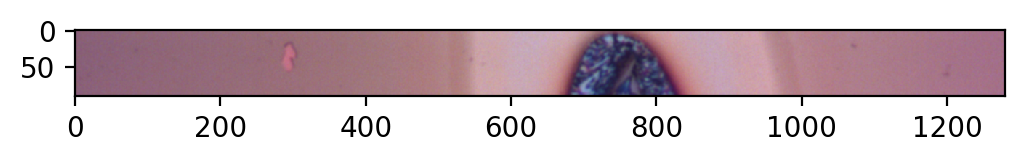

67.5

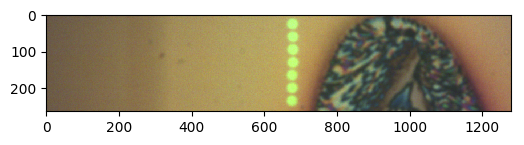

In [7]:
specimpath = '/home/vandover/Documents/Data/19F97_MoOx_GP_AL/Calibration_Images/SpecRefImg_01.bmp'
optimpath = '/home/vandover/Documents/Data/19F97_MoOx_GP_AL/Calibration_Images/OptRefImg_01.bmp'
refspec = imageio.imread(specimpath)
refopt = imageio.imread(optimpath)

plt.figure(dpi=200)
plt.imshow(refopt[450:540,:,:])
plt.show()
plt.figure(dpi=100)
plt.imshow(refspec[315:580,:,:])
d = refspec.shape[1]* 0.0003048263*35
d/2*np.sin(0.95/2*d)
90*0.75

In [8]:
#important for setting up your output dictionaries
channel = ['r','g','b','bw']
ImgTrs = {}
ImgDict = {}
xys = {}
FPs = []
testkeys = []
for file in glob.glob(imagespath+'*.bmp'):
    FPs.append(file)
mirror = cv2.imread(mpath,0)[450:540,:]
# for jdx in np.arange(5):
for file in FPs:
#     file = FPs[jdx]
    fname = os.path.basename(file)[:-4]
    s = fname.split('_')
    tau = str(int(s[2]))
    T = str(int(s[3]))
    key = '_'.join(('tau',tau,'T',T))
    testkeys.append(key)
    xys[key] = (int(s[0][1:]),int(s[1]))
    ImgTrs[key] = {}
    ImgDict[key] = {}
    if RGB==True:
        ImgDict[key]['whole'] = img = np.array(cv2.imread(file)[450:540,:,:],dtype='uint8')
        for ch in [0,1,2]:
            img = np.array(cv2.imread(file)[:,:,ch][450:540,:],dtype='uint8')
            ImgDict[key][channel[ch]]=img
#         ImgDict[key]['bw'] = np.array(cv2.imread(file,0)[400:530,:],dtype='uint8')
        ImgDict[key]['bw']=(np.sum(np.array([ImgDict[key][c] for c in ['r','g','b']]),axis=0)/3).astype('uint8')
        img = ImgDict[key]['bw']
        Trs = MSI_Transition_Finder(filepath=img,mpath=mirror,blur=10,h_thresh=10,Gpromfilt=0,v_cutoff=0,pixel_size=0.75,norm=False,ImgIO=True,plotting=False)
#         I = np.sum(img,axis=0)
#         I = I - np.arange(len(I))*(I[-2]-I[0])/len(I)
#         grad = np.gradient(I)
#         grad = np.sqrt(grad*grad)
#         plt.plot(smooth(grad,30))
        
        ImgTrs[key]['center'] = Trs['center']
        if Trs['transitions']!='none':
            ImgTrs[key]['Tr_indicies'] = Trs['TR_idx']
            ImgTrs[key]['heights'] = Trs['transitions']['heights']
            ImgTrs[key]['FWHMs'] = Trs['transitions']['FWHMs']
            ImgTrs[key]['proms'] = Trs['transitions']['prominences']
            ImgTrs[key]['widths'] = Trs['transitions']['widths']
            ImgTrs[key]['distance_from_center'] = Trs['transitions']['distance_from_center']
            ImgTrs[key]['gradient'] = Trs['Gradient']
        else:
            ImgTrs[key] = 'none'

    else:

        img = cv2.imread(file,0)
#         print(img.shape)
        ImgDict[key]=img
        Trs = MSI_Transition_Finder(filepath=img,mpath=mpath,blur=4,h_thresh=10,Gpromfilt=50,norm=True,plotting=False,v_cutoff=0)
#         print(Trs)
        ImgTrs[key]['center'] = Trs['center']
        if Trs['transitions']!='none':
            ImgTrs[key]['Tr_indicies'] = Trs['TR_idx']
            ImgTrs[key]['heights'] = Trs['transitions']['heights']
            ImgTrs[key]['FWHMs'] = Trs['transitions']['FWHMs']
            ImgTrs[key]['proms'] = Trs['transitions']['prominences']
            ImgTrs[key]['widths'] = Trs['transitions']['widths']
            ImgTrs[key]['distance_from_center'] = Trs['transitions']['distance_from_center']
            ImgTrs[key]['gradient'] = Trs['Gradient']
        else:
            ImgTrs[key] = 'none'

# Reflectance Spectroscopy

### Output is a dictionary of reflectance data vs lg-LSA space. The keys to the dictionary are the LSA conditions (tau_xxxxx_T_xxxx) as a string

In [9]:
#This is optical reflectance data and analysis
data_filepath = '/home/vandover/Documents/Data/19F97_MoOx_GP_AL/Spectroscopy_Full/'
Blank_filepath = '/home/vandover/Documents/Data/19F97_MoOx_GP_AL/Spectroscopy_Full/Blank/blank_00.csv'
Mirror_filepath = '/home/vandover/Documents/Data/19F97_MoOx_GP_AL/Spectroscopy_Full/Mirror/mirror_00.csv'

In [10]:
ReflDict = {}
Location = {}
FPs = []
keys = []
plotting = False
#extracting the data from the .csv files
for i in glob.glob(data_filepath+'*.csv'):
    #extracting lasGO coordinates and anneal conditions
    filename = os.path.basename(i)
    x = filename.split('_')
    string = '_'.join(['tau',str(int(x[2])),'T',str(int(x[3][:-4]))])
    FPs.append(i)
    keys.append(string)

for idx in np.arange(len(FPs)):#np.arange(5)
    data_fn = FPs[idx]
    string = keys[idx]
    smooth_data = get_spects(data_fn,Mirror_filepath,Blank_filepath)
    wl = smooth_data[0]
    wl_range = wl[(wl>=400) & (wl<= 850)]
    #Dictionary Generation
    print(idx)
    ReflDict[string] = smooth_data[2][[(wl>=400) & (wl<= 850)][0],:]
    Location[string] = (smooth_data[3]['scan center'][0],smooth_data[3]['scan center'][1])

    if plotting == True: 
        
        data = smooth_data[2][[(wl>=400) & (wl<= 800)][0],:]
        plt.imshow(data,aspect='auto',extent=[0,2.00,min(wl_range),max(wl_range)])
        plt.title(string)
        plt.xlabel('Anneal Space in mm')
        plt.ylabel('wavelength in nm')
        plt.show()
        plt.close()
wl = wl_range

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113


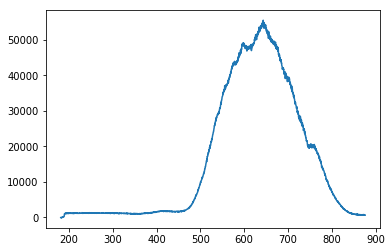

In [11]:
# intensity of light coming in
f = open(Mirror_filepath)
reader = csv.reader(f,delimiter=',')
raw = np.array([row for row in reader][13:],dtype=float)
plt.plot(raw[:,0],raw[:,1])

Finding the transitions from the optical reflectance data

In [11]:
ReflTrs = {}
for key in list(ReflDict):
    print(key)
    spec_map = ReflDict[key]
    ReflTrs[key] =  Spectroscopy_Transiton_Finder(spec_map,h_thresh=5,h_cutoff=15,s_param=1,cond=key,plotting=False)

tau_2150_T_1135
tau_1398_T_610
tau_250_T_880
tau_10000_T_865
tau_967_T_430
tau_2750_T_895
tau_462_T_850
tau_10000_T_460
tau_2750_T_415
tau_1028_T_775
tau_711_T_475
tau_1093_T_1180
tau_1681_T_565
tau_2022_T_805
tau_320_T_400
tau_1315_T_880
tau_384_T_460
tau_10000_T_535
tau_10000_T_1075
tau_4782_T_1255
tau_2924_T_640
tau_340_T_1045
tau_1788_T_925
tau_556_T_595
tau_804_T_850
tau_4497_T_505
tau_3976_T_565
tau_250_T_970
tau_250_T_505
tau_2150_T_970
tau_967_T_700
tau_1093_T_505
tau_5085_T_895
tau_250_T_595
tau_1681_T_760
tau_2924_T_1300
tau_250_T_640
tau_340_T_550
tau_1163_T_655
tau_591_T_655
tau_629_T_1300
tau_4497_T_1150
tau_10000_T_1300
tau_1681_T_400
tau_1398_T_730
tau_4228_T_850
tau_5750_T_1195
tau_4497_T_955
tau_1093_T_1300
tau_462_T_505
tau_250_T_835
tau_3307_T_820
tau_5407_T_1300
tau_362_T_745
tau_669_T_1030
tau_4497_T_400
tau_409_T_1255
tau_1315_T_1015
tau_250_T_430
tau_711_T_550
tau_967_T_820
tau_523_T_1135
tau_2022_T_1060
tau_1788_T_1240
tau_1028_T_940
tau_10000_T_595
tau_1028_T_1

# Bring in the XRD

This is predicated on one having the integrated 1D data coming from an .h5 file that Dan produces


If you do NOT have this, see the PseudoXRD_mapper code and generate them first. You'll be able to load them in after that.

In [12]:
OG_path = '/home/vandover/zoo-fs/data/CHESS/2019-12-CHESS-3B/MoO_19F97/MoO_19F97_all_oned.h5'

In [14]:
file = h5.File(OG_path,'r')
xrd_exp_files = file['exp']
data = []
xrdDict = {}
xrdQs = {}
xrdAttrs = {}
x = []
for idx, params in enumerate(xrd_exp_files):
    anneal_conditions = xrd_exp_files[params]
    stripe = list(anneal_conditions.keys())
    stripe.sort(key=int)
    name = params
#     La_comp = np.round(anneal_conditions.attrs['La.L.AtFrac'],3)
    xpos,ypos = (anneal_conditions.attrs['xw'],anneal_conditions.attrs['yw'])
    

    for jdx, scan_num in enumerate(stripe):        
        Q,I = anneal_conditions[scan_num]['integrated_1d']
        
        if scan_num == '0':
            data = np.append(data, I[:-24], axis=0)
        else:
            data = np.vstack((data,I[:-24]))


        xrdDict[name] = data.T
        xrdQs[name] = Q[:-24]

    data = []   
    xrdAttrs[name] = xpos,ypos
    
xrdkeys = dwellsort(list(xrdAttrs))

# for key in xrdkeys[-10:]:
#     plt.figure()
#     plt.title(key)
#     x = np.log10(xrdDict[key][1:])
#     plt.imshow(x,aspect='auto',extent=[0,1000,max(Q),min(Q)])
#     plt.show()

In [15]:
def xrd_transition_finder(xrd_map,cond='string',Gpromfilt=0,h_thresh=10,h_cutoff=12,pix_siz=10,s_param=2,plotting=True):
    TransitionStats = {}
    
    im = sharpen_y(xrd_map)
    grad_im = []
    xpix = im.shape[1]
    for idx in np.arange(im.shape[0]):
        x = np.gradient(im[idx,:])
        x = np.sqrt(x*x)
        grad_im.append(x)
        
    grad_im = np.array(grad_im)
    grad = ndimage.gaussian_filter1d(np.sum(grad_im,axis=0),s_param)
    grad = grad/max(grad)    
    
    correlation = ndimage.correlate(grad,grad[::-1],mode='wrap')
    xrd_center = (len(correlation))*0.5 + (np.argmax(correlation)-(len(correlation))*0.5)*0.5
    
    a_sigma = abs((np.std(grad[0:h_cutoff])+np.std(grad[-h_cutoff:]))*0.5)
    a_mu = abs((np.mean(grad[0:h_cutoff])+np.mean(grad[-h_cutoff:]))*0.5)
    grad = grad-a_mu
    
    h_filt = h_thresh*a_sigma
    
    
    xrd_trans = signal.find_peaks(grad,prominence=Gpromfilt,width=[0.001*xpix,0.25*xpix],height=h_filt)
    
    TransitionStats['center'] = xrd_center
    TransitionStats['TR_idx'] = xrd_trans[0]+1
    TransitionStats['transitions'] = {}
    TransitionStats['transitions']['widths'] = xrd_trans[1]['widths']
    TransitionStats['transitions']['FWHMs'] = signal.peak_widths(grad,xrd_trans[0],rel_height=0.5)[0]
    TransitionStats['transitions']['heights'] = xrd_trans[1]['peak_heights']
    TransitionStats['transitions']['prominences'] = xrd_trans[1]['prominences']
    TransitionStats['transitions']['distance_from_center'] = (xrd_trans[0]+1-xrd_center)*pix_siz 
    TransitionStats['StripeCenterDistFromImageCenter'] = (xrd_trans[0]+1-xrd_center)*pix_siz-(int(0.5*im.shape[1])-xrd_center)*pix_siz
    TransitionStats['horizontal FOV'] = xpix*pix_siz
    TransitionStats['LSA_condition'] = cond
    TransitionStats['gradient'] = grad
    if plotting==True:
        fig,ax = plt.subplots(2,1,constrained_layout=True)
        
        fig.suptitle(cond)
        ax[0].imshow(xrd_map,aspect='auto')
        ax[0].axvline(xrd_center,c='orchid')
        for tr in xrd_trans[0]:
            ax[0].axvline(tr,c='goldenrod')
        ax[1].plot(grad)
        ax[1].axvline(xrd_center,c='orchid')
        for tr in xrd_trans[0]:
            ax[1].axvline(tr,c='goldenrod')
        
        plt.show()
        plt.close(fig)
    return TransitionStats

xrdkeys=dwellsort(list(xrdDict),Temp=True)
xrdTrs = {}
for key in xrdkeys: 
    xrd_map = xrdDict[key]
#     plt.imshow(xrd_map,aspect='auto')
#     plt.show()
    xrdTrs[key] = xrd_transition_finder(xrd_map,h_thresh=5,h_cutoff=15,s_param=1,cond=key,plotting=False)
xrdkeys = dwellsort(list(xrdDict))

# All Three Techniques correlated against one another

Each condition has all three techniques plotted against one another: 

- The spatially resloved maps

- The gradients within those analyzed regions
    
The summary scatter plots and histograms are the last three plots which contain the mean, median, and standard deviations   


DISCLAIMER: ALL PDF LINES MUST BE ACTIVE IN ORDER FOR THE DOCUMENT TO SAVE CORRECTLY

tau_10000_T_1300
Optical Spectroscopy
0.806
Optical XRD
0.571
Spectroscopy XRD
0.626
tau_10000_T_1225
Optical Spectroscopy
0.823
Optical XRD
0.492
Spectroscopy XRD
0.571
tau_10000_T_1150
Optical Spectroscopy
0.806
Optical XRD
0.554
Spectroscopy XRD
0.589
tau_10000_T_1075
Optical Spectroscopy
0.801
Optical XRD
0.532
Spectroscopy XRD
0.557
tau_10000_T_1000
Optical Spectroscopy
0.939
Optical XRD
0.576
Spectroscopy XRD
0.538
tau_10000_T_940
Optical Spectroscopy
0.738
Optical XRD
0.383
Spectroscopy XRD
0.606
tau_10000_T_865
Optical Spectroscopy
0.884
Optical XRD
0.484
Spectroscopy XRD
0.561
tau_10000_T_805
Optical Spectroscopy
0.76
Optical XRD
0.511
Spectroscopy XRD
0.575
tau_10000_T_760
Optical Spectroscopy
0.486
Optical XRD
0.195
Spectroscopy XRD
0.798
tau_10000_T_700
Optical Spectroscopy
0.749
Optical XRD
0.71
Spectroscopy XRD
0.857
tau_10000_T_640
Optical Spectroscopy
0.725
Optical XRD
0.463
Spectroscopy XRD
0.633
tau_10000_T_595
Optical Spectroscopy
0.67
Optical XRD
0.16
Spectroscopy X

tau_340_T_1045
Optical Spectroscopy
0.577
Optical XRD
0.603
Spectroscopy XRD
0.413
tau_340_T_550
Optical Spectroscopy
0.71
Optical XRD
0.437
Spectroscopy XRD
0.383
tau_320_T_400
Optical Spectroscopy
0.818
Optical XRD
0.555
Spectroscopy XRD
0.539
tau_250_T_1225
Optical Spectroscopy
0.461
Optical XRD
0.611
Spectroscopy XRD
0.389
tau_250_T_1165
Optical Spectroscopy
0.792
Optical XRD
0.385
Spectroscopy XRD
0.318
tau_250_T_1105
Optical Spectroscopy
0.53
Optical XRD
0.538
Spectroscopy XRD
0.486
tau_250_T_970
Optical Spectroscopy
0.799
Optical XRD
0.361
Spectroscopy XRD
0.371
tau_250_T_880
Optical Spectroscopy
0.7
Optical XRD
0.639
Spectroscopy XRD
0.56
tau_250_T_835
Optical Spectroscopy
0.65
Optical XRD
0.446
Spectroscopy XRD
0.576
tau_250_T_790
Optical Spectroscopy
0.79
Optical XRD
0.531
Spectroscopy XRD
0.598
tau_250_T_700
Optical Spectroscopy
0.789
Optical XRD
0.567
Spectroscopy XRD
0.565
tau_250_T_640
Optical Spectroscopy
0.753
Optical XRD
0.425
Spectroscopy XRD
0.401
tau_250_T_595
Optic

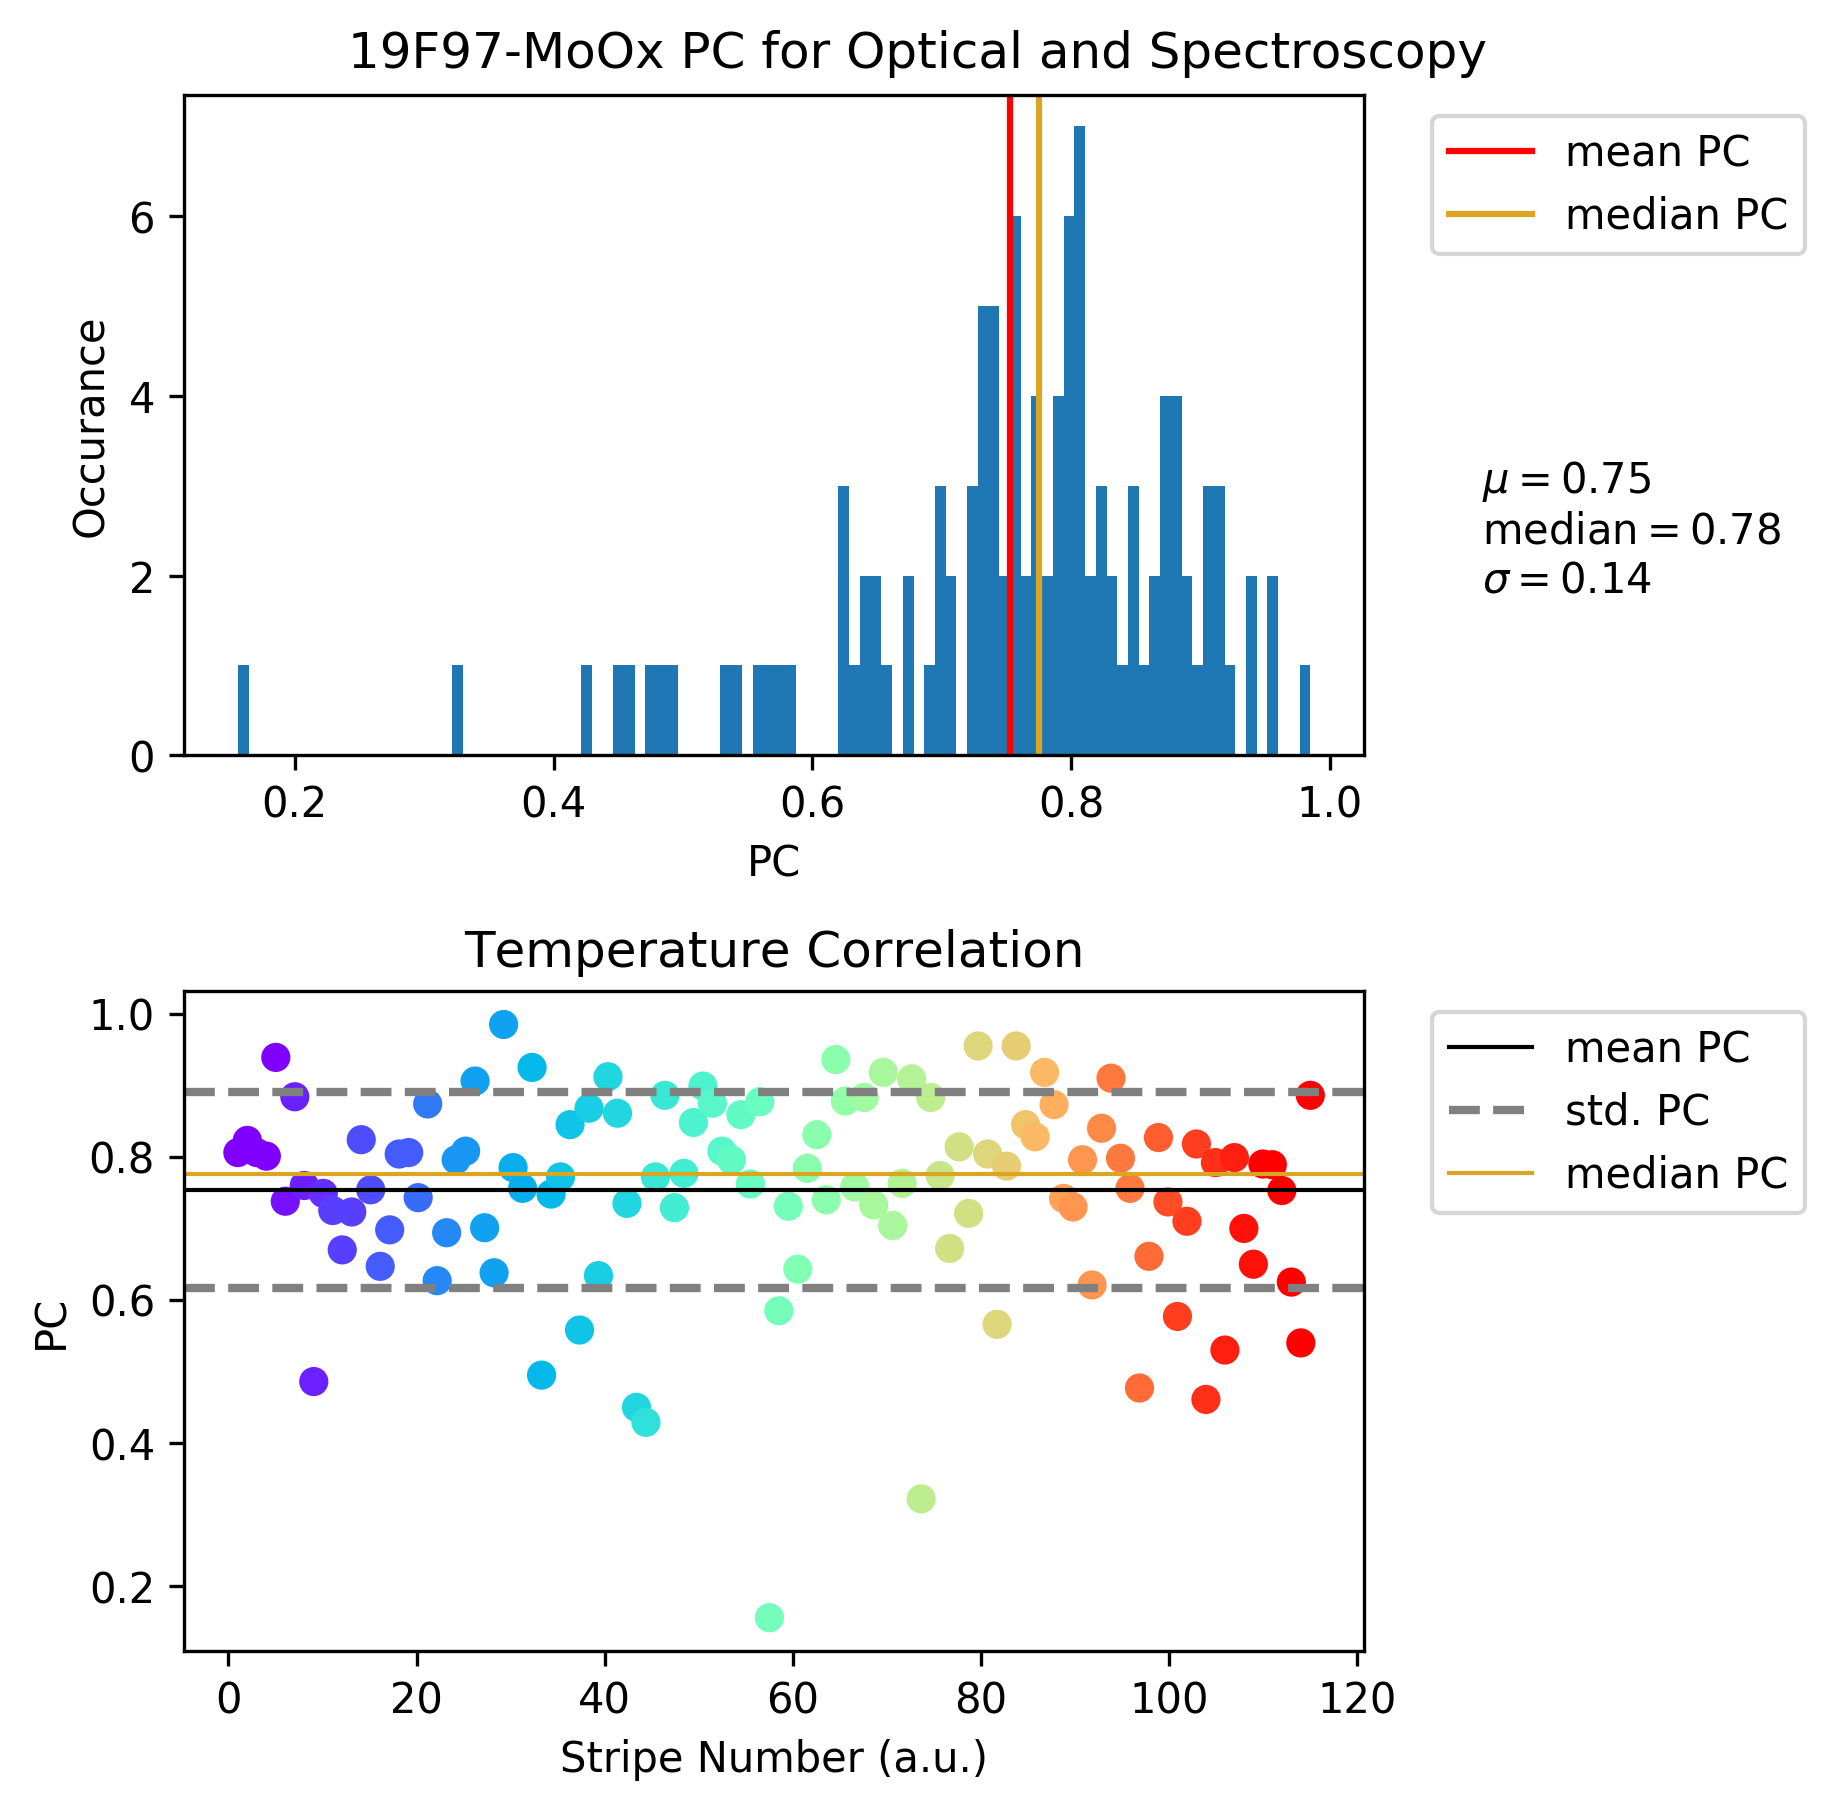

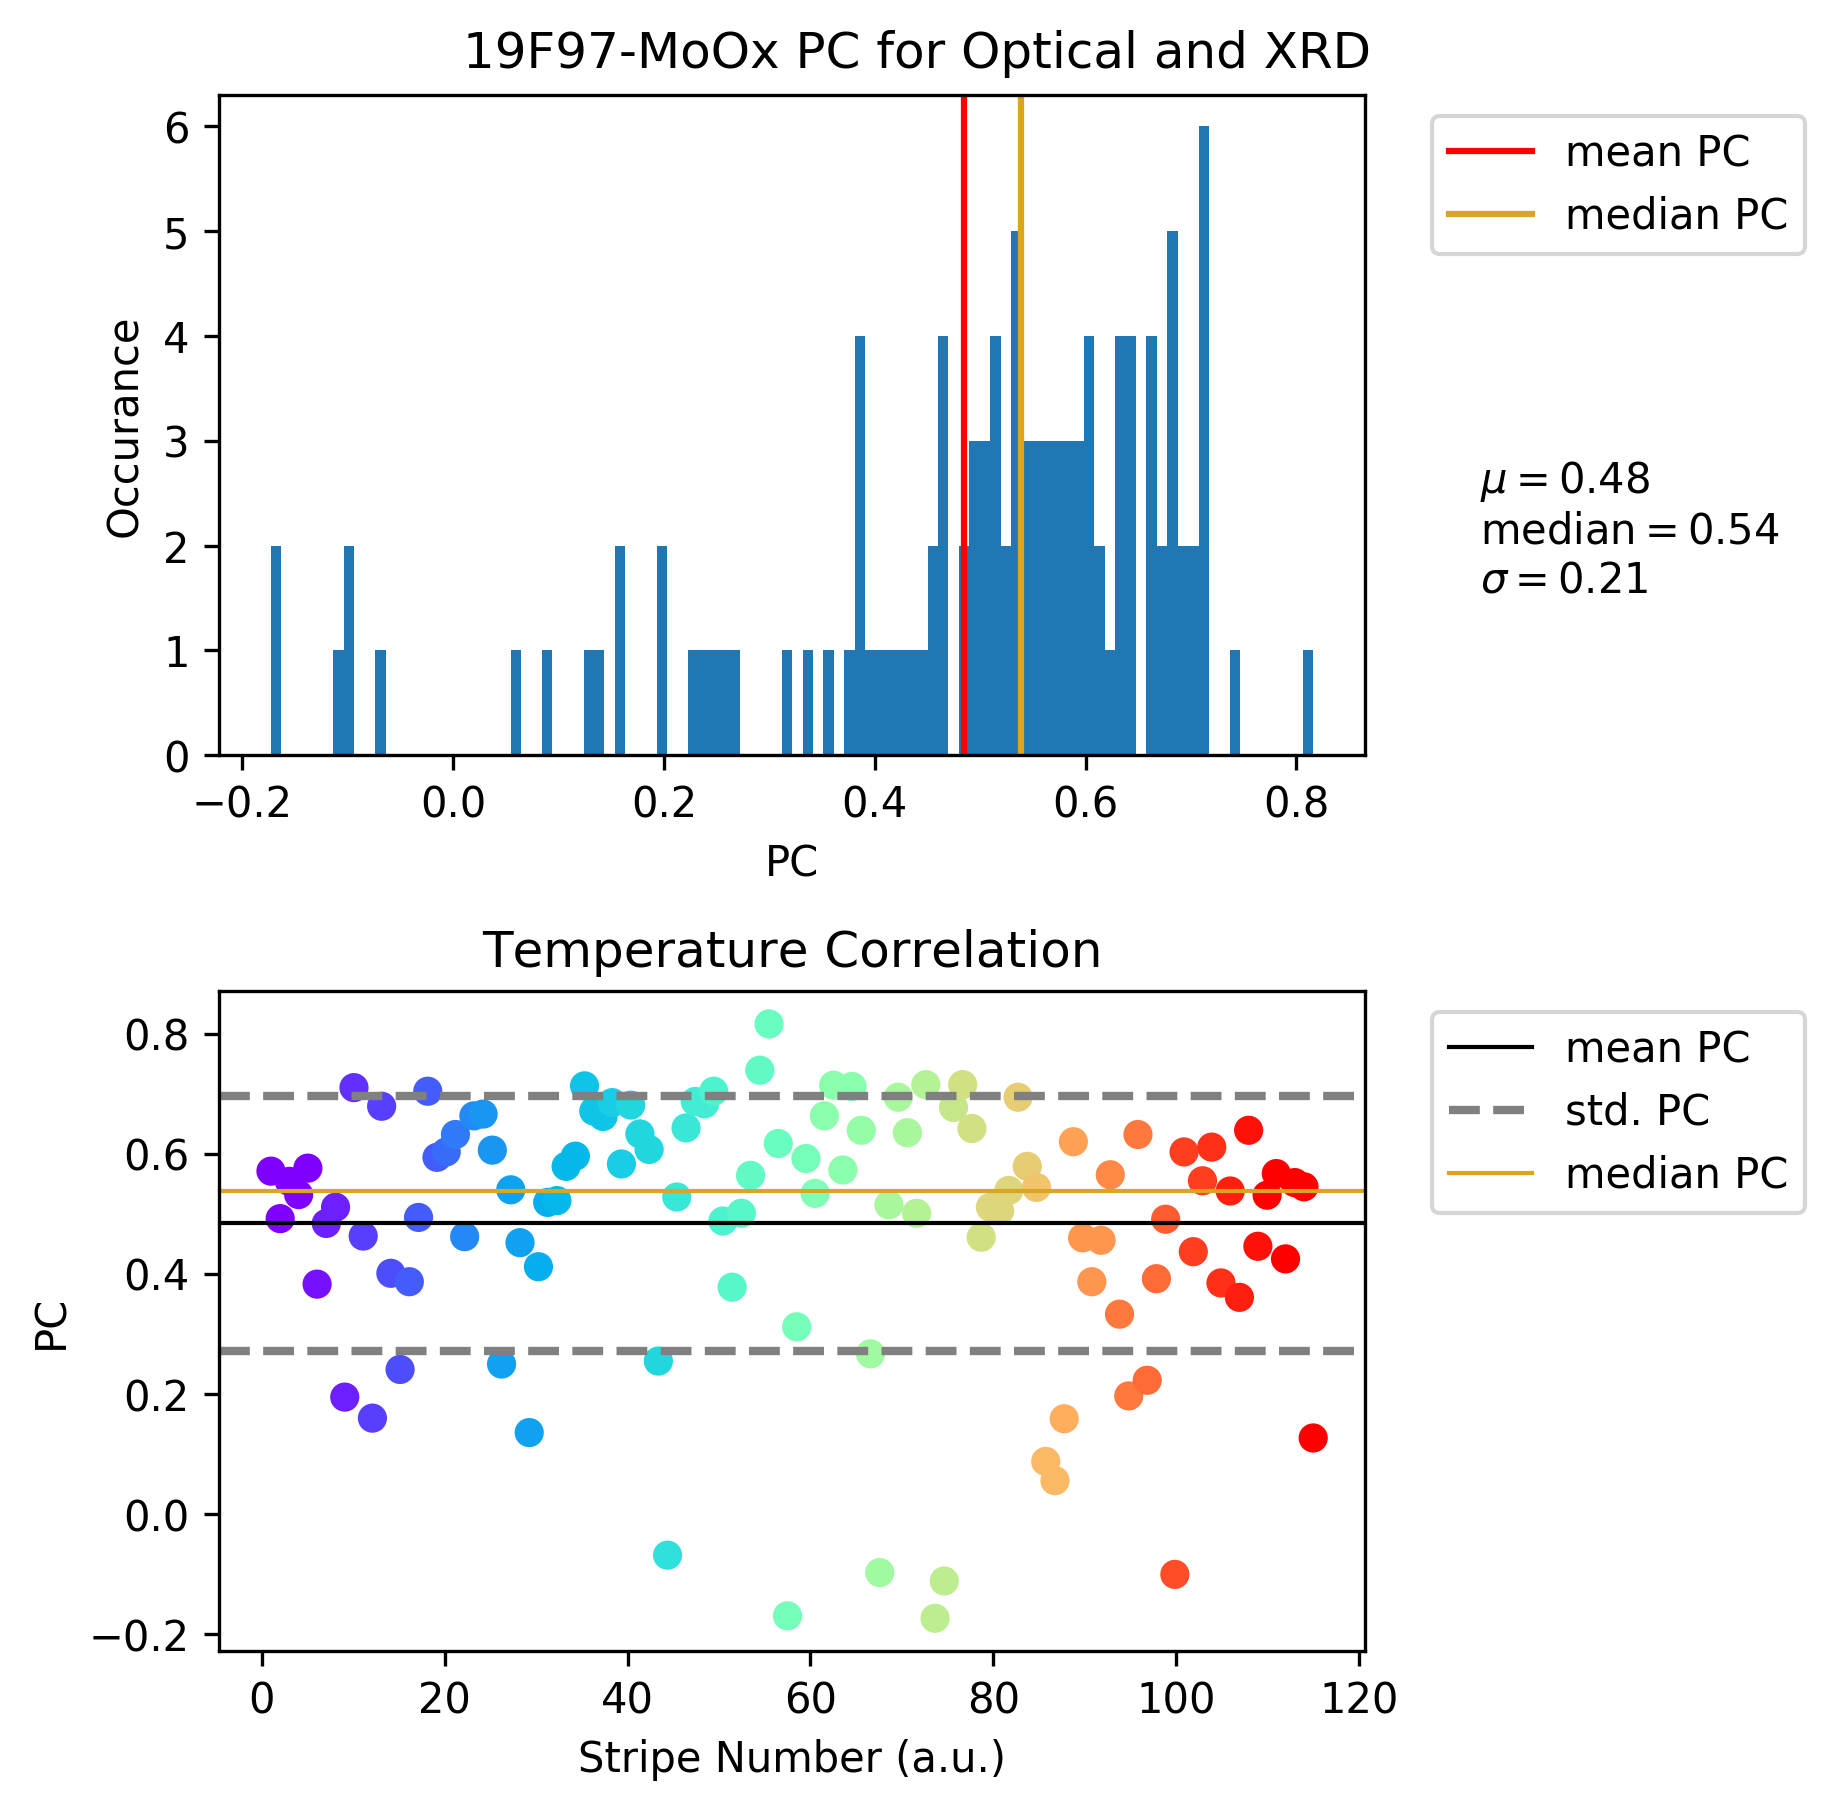

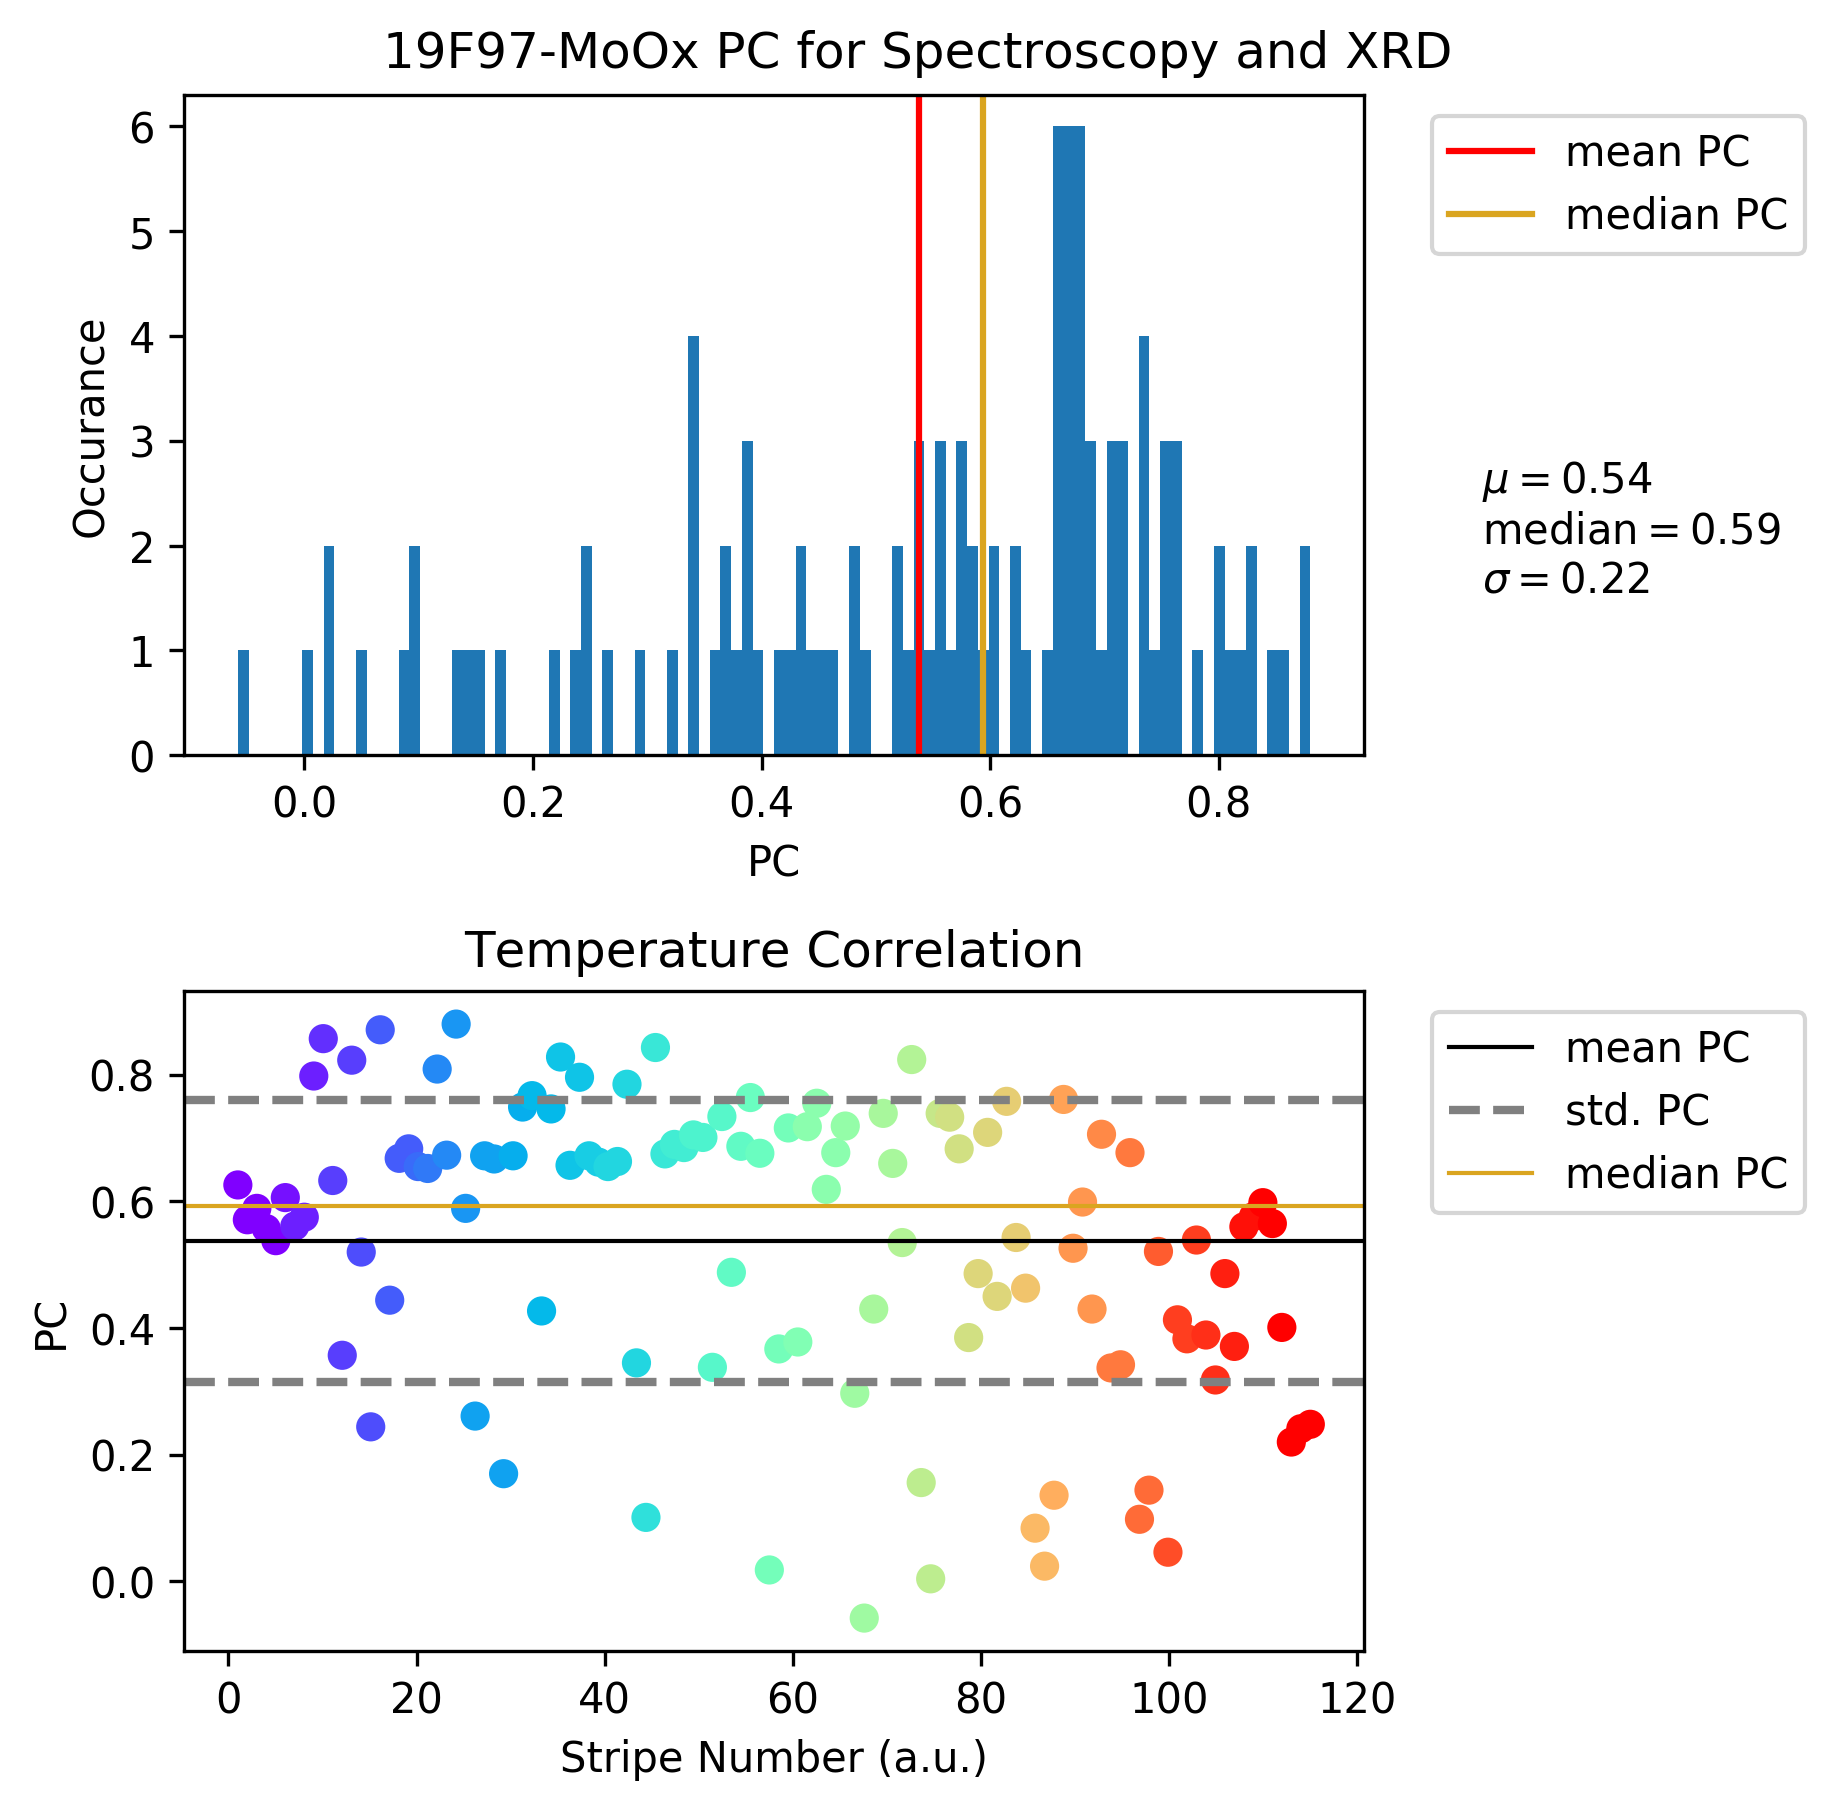

In [16]:
# where to write the output document to
basepath = '/home/vandover/Documents/Data/19F97_MoOx_GP_AL/'

# this needs to be set to True if you want to see the maps up against one another 
plotting = True

# This is more important when comparing the optical to either technique, because of the 
# resolution difference
resample = True

# instantiating the pdf to be made. ALL pdf lines must be enabled. uncomment this line if desired
pdf = PDF_saver.PdfPages(basepath+MatSysName+'_3-Technique-Anaylsis.pdf')

# there is a slight discrepancy with the dwells for the active learned samples vs what was requested
# it is a rounding issue that can be overcome by sorting the same way. 
xkeys = dwellsort(list(xrdDict),Temp=False)[::-1] 
okeys = dwellsort(list(ImgDict),Temp=False)[::-1]

# It is helpful to color each condition according to its temperature. This code extracts the range
# of temperatures and puts them on a rainbow scale, red being hot, purple being cold
demkeys = dwellsort(list(ReflDict),Temp=True)
splitlitst = np.array([key.split('_') for key in demkeys])

# Defining a list of hexcode colors that make a rainbow! This gives the plot another dimension
# it's sorted by increasing temperature
utau = sorted(np.unique(splitlitst[:,1]),key=int)
uT = sorted(np.unique(splitlitst[:,3]),key=int)
ckey_dict = {}
colorsarray = cm.rainbow(np.linspace(0,1,len(uT)))

for idx,T in enumerate(uT):
    for tau in utau:
        c =  colorsarray[idx]
        ckey_dict['tau_'+str(tau)+'_T_'+str(T)] = c
ckey = []
for key in demkeys:
    ckey.append(ckey_dict[key])

# the dictionary that will house the gradient information for easier correlation
graddict = {}

# the correlation statistics are stored here
PC = {}

# iterating through the conditions and extracting all the information from each of the techniques
for idx in np.arange(len(xkeys)):
    #This is a diagnostic parameter important for determining where stripes were annealed
    xpos = xys[okeys[idx]][0]
    ypos = xys[okeys[idx]][1]
    xkey = xkeys[idx]
    key = okeys[idx]
    
    #inputing the pixel sizes once so an error doesn't propogate
    xps = 10
    sps = 10
    ops = 0.926
    TechPSs = [ops,sps,xps]
    TechNames = ['Optical','Spectroscopy','XRD']
    
    # each technique spans a different anneal space. Each technique needs to be tailored accordingly.
    # For this sample, the x-ray maps span 1 mm, whereas the optical and spectroscopy are ~1.2 mm 
    # and 2.01 mm respectively. This will change depending on the material system, the zoom of the
    # optical camera, the space collected by the spectroscopy and that of the XRD. 
    
    #defining the anneal space span for each technique
    oscale = ImgDict[key]['bw'].shape[1]*ops
    sscale = ReflDict[key].shape[1]*sps
    xscale = xrdDict[xkey].shape[1]*xps
    
    #locating the smallest one and determining the appropriate crop pixel
    scales = [oscale,sscale,xscale]
    minscale = min(scales)
    oscale = int(np.round(0.5*(oscale-minscale)/ops))
    sscale = int(np.round(0.5*(sscale-minscale)/sps))
    xscale = int(np.round(0.5*(xscale-minscale)/xps))
    scales = [oscale,sscale,xscale]

    #loading the technique maps
    omap = np.array(ImgDict[key]['bw'],dtype=float) # the image needs to be in float value for calculations
    smap = ReflDict[key][300:1300,:] # the spectrometer is only good for the following wavelength values
    xmap = xrdDict[xkey]
    
    #was having issues with some of the transition finding/gradient calculations. Re-did the gradient
    #calculations here
    isum = np.sum(omap,axis=0)
    isum = ndimage.gaussian_filter1d(isum,10)
    isum = isum/max(isum)
    g = np.gradient(isum)
    g = np.sqrt(g*g)
    g = g/max(g)
    
    h_cutoff = 100
        
    a_sigma = abs((np.std(g[0:h_cutoff])+np.std(g[-h_cutoff:]))*0.5)
    a_mean = abs((np.mean(g[0:h_cutoff])+np.mean(g[-h_cutoff:]))*0.5)
    h_filt = 3*a_sigma
    xpix = len(g)
    g = g - a_mean
    
    # Locating the transitions
    ostats = signal.find_peaks(g,prominence=.05,width=[0.001*xpix,0.25*xpix],height=h_filt)[0]
    sstats = Spectroscopy_Transiton_Finder(smap,Gpromfilt=.05,h_thresh=3,h_cutoff=50,s_param=.5,cond=key,plotting=False)
    xstats = xrd_transition_finder(xmap,h_thresh=3,h_cutoff=10,s_param=0.5,cond=xkey,plotting=False)
    
    # redefined maps so that they span approximately the same anneal space. also applying a smoothing function
    omap = np.array(ImgDict[key]['whole'][:,oscale:-oscale])
    smap = ndimage.gaussian_filter(ReflDict[key][300:1300,:][:,sscale:-sscale],1)
    xmap = xrdDict[xkey]
    
    # Taking the gradients along the correct scale
    ograd = g[oscale:-oscale][1:-1]
    sgrad = sstats['gradient'][sscale:-sscale][1:-1]
    xgrad = xstats['gradient'][1:-1]
    
    TechGrads = [ograd,sgrad,xgrad]
    
    if resample==True:
        y = signal.resample(ograd,len(xgrad))
        ops = 10
        TechPSs = [ops,sps,xps]
        TechGrads = [y,sgrad,xgrad]

    #the transitions that were located were for each techniques FULL map. this appropriately shifts
    #them to the proper cropped location
    otrs = ostats-oscale
    strs = sstats['TR_idx']-sscale
    xtrs = xstats['TR_idx']-xscale
    
    # anneal space definition
    ox = np.linspace(0,sps*len(ograd),len(ograd))
    sx = np.linspace(0,sps*len(sgrad),len(sgrad))
    xx = np.linspace(0,xps*len(xgrad),len(xgrad))
    
    #plotting the maps, transitions in the maps, and the gradients. The header contains
    #The conditions and the location
    if plotting ==True:
        fig,ax = plt.subplots(3,2,figsize=(6.4,6.4),constrained_layout=True,dpi=150)
        fig.suptitle(f'{MatSysName}  cond: {key}  x: {xpos}  y: {ypos}')
        ax[0,0].imshow(ImgDict[key]['whole'],aspect='auto',extent=[0,omap.shape[1]*ops,omap.shape[0]*ops,0])
        for tr in (otrs[(otrs<len(ograd))&(otrs>0)])*ops:
            ax[0,0].axvline(tr,ymin=0.5,ymax=1,c='goldenrod')
        ax[1,0].imshow(smap,aspect='auto',extent=[0,smap.shape[1]*sps,min(wl),max(wl)])
        for tr in (strs[(strs<len(sgrad))&(strs>0)])*sps:
            ax[1,0].axvline(tr,ymin=0.5,ymax=1,c='goldenrod')
        ax[2,0].imshow(ndimage.gaussian_filter(xmap,1),aspect='auto',
                       extent=[0,xmap.shape[1]*xps,41,20])#max(Q),min(Q)])
        for tr in xtrs[(xtrs<len(xgrad))&(xtrs>0)]*xps:
            ax[2,0].axvline(tr,ymin=0.5,ymax=1,c='goldenrod')

        ax[0,1].plot(ograd,c='darkviolet')
        ax[1,1].plot(sgrad,c='dodgerblue')
        ax[2,1].plot(xgrad,c='forestgreen')
#         plt.show(fig)
        pdf.savefig(fig)
        plt.close(fig)
    
    # Gotta correlate the gradients now. The off diagonals of the correlation matrix is the 
    graddict[key] = {}
    PC[key] = {}
    print(key)
    for adx,bdx in [(0,1),(0,2),(1,2)]:
        
        #loading in the technique pairs Opt:Spec, Opt:XRD, Spec:XRD
        a = TechGrads[adx]
        b = TechGrads[bdx]
        aps = TechPSs[adx]
        bps = TechPSs[bdx]
        aname = TechNames[adx]
        bname = TechNames[bdx]
        print(aname,bname)
        
        #Turning the gradients into  splines for the optimized correlation functions
        afxn,anormgrad,axgrad,acidx = GradSigNormAndCenter(signal=a,pixelsize=aps,CFon=True,plotting=False)
        bfxn,bnormgrad,bxgrad,bcidx = GradSigNormAndCenter(signal=b,pixelsize=bps,CFon=True,plotting=False)

        #storing them into the appropriate dictionary to be called upon later
        graddict[key][f'{aname} spline fxn'] = afxn
        graddict[key][f'{bname} spline fxn'] = bfxn

        
        # finding the shared space for the two techniques to be compared
        maxx = min(max(axgrad),max(bxgrad)) 
        sharedx = np.linspace(0,maxx,501)
        graddict[key][f'x for {aname} and {bname}'] = sharedx

        # optimizes the Gradients over the shared space within some distance from eachother
        xshift, PC0, newx, nafxn, nbfxn = bestPC(sharedx,bfxn,afxn,shift_tol=15,plotting=False)
        PC[key][f'PC for {aname} and {bname}'] = PC0
        print(PC0)
    print('')
    
# Plotting that shows the comparison statistics for the number of stripes investigated
stripe = np.linspace(1,len(xrdkeys)+1,len(xrdkeys))
for TechCorr in list(PC[okeys[0]]):
    PC0 = np.array([PC[key][TechCorr] for key in okeys])
    mu = np.mean(PC0)
    sigma = np.std(PC0)
    median = np.median(PC0)

    textstr = '\n'.join((
        r'$\mu=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\sigma=%.2f$' % (sigma, )))
    
    fig,ax = plt.subplots(2,1,dpi=300,figsize = (6,6),constrained_layout=True)
    fig.suptitle(f'{MatSysName} {TechCorr}')
    ax[0].set_xlabel('PC')
    ax[0].set_ylabel('Occurance')
    ax[0].hist(PC0,bins=100)
    ax[0].axvline(np.mean(PC0),c='red',label='mean PC')
    ax[0].axvline(np.median(PC0),c='goldenrod',label='median PC')
    ax[0].legend(loc='upper left',bbox_to_anchor=(1.04,1))
    ax[0].text(1.1, 0.25, textstr,transform=ax[0].transAxes)
    ax[1].set_ylabel('PC')
    ax[1].set_xlabel('Stripe Number (a.u.)')
    ax[1].scatter(stripe,PC0,c=ckey)
    ax[1].axhline(np.mean(PC0),c='k',linewidth=1,label='mean PC')
    ax[1].axhline(np.mean(PC0)+np.std(PC0),c='gray',linewidth=2,linestyle='--',label='std. PC')
    ax[1].axhline(np.mean(PC0)-np.std(PC0),c='gray',linewidth=2,linestyle='--')
    ax[1].axhline(np.median(PC0),c='goldenrod',linewidth=1,label='median PC')
    ax[1].set_title('Temperature Correlation')
    ax[1].legend(loc='upper left',bbox_to_anchor=(1.04,1))
    plt.show(fig)
    pdf.savefig(fig)
    plt.close(fig)
pdf.close()

# Correlation of Spectroscopy and Optical

Here is the statistical analysis of the gradients in the techniques. One can turn on the plotting and the resampling in order to troubleshoot and plat with correlation.

In [ ]:
#change these if you want
plotting = False
resampling = True
dpi = 300

demkeys = dwellsort(list(ReflDict),Temp=True)
splitlitst = np.array([key.split('_') for key in demkeys])

# Defining a list of hexcode colors that make a rainbow! This gives the plot another dimension
# it's sorted by increasing temperature
utau = sorted(np.unique(splitlitst[:,1]),key=int)
uT = sorted(np.unique(splitlitst[:,3]),key=int)
ckey_dict = {}
colorsarray = cm.rainbow(np.linspace(0,1,len(uT)))

for idx,T in enumerate(uT):
    for tau in utau:
        c =  colorsarray[idx]
        ckey_dict['tau_'+str(tau)+'_T_'+str(T)] = c
ckey = []
for key in demkeys:
    ckey.append(ckey_dict[key])


    
# The bulk code that correlates the optical to the spectroscopy    
PC0 = []
corr = {}
graddict = {}
for key in demkeys:    
    if resampling==True:
        y = np.sum(ImgDict[key]['bw'],axis=0)
        y = y-np.arange(len(y))*(int(y[-1])-int(y[0]))/len(y)
        y = signal.resample(y,len(ReflTrs[key]['gradient'][41:-41]))
        ygrad = np.gradient(y)
        ygrad = np.sqrt(ygrad*ygrad)
        fxn,normgrad,xgrad,cidx = GradSigNormAndCenter(signal=ReflTrs[key]['gradient'][41:-41][2:-2]
                                                       ,pixelsize=10)
        afxn,anormgrad,axgrad,acidx = GradSigNormAndCenter(signal=ygrad[2:-2],pixelsize=10)
        graddict[key] = {}
        graddict[key]['Spectroscopy'] = fxn
        graddict[key]['Optical'] = afxn
        
        
    else:
        fxn,normgrad,xgrad,cidx = GradSigNormAndCenter(signal=ReflTrs[key]['gradient']
                                                       ,pixelsize=10)
        afxn,anormgrad,axgrad,acidx = GradSigNormAndCenter(signal=ndimage.gaussian_filter(ImgTrs[key]['gradient'],15),pixelsize=0.926)
        graddict[key] = {}
        graddict[key]['Spectroscopy'] = fxn
        graddict[key]['Optical'] = afxn
    
    # finding the shared space
    maxx = min(max(xgrad),max(axgrad)) 
    sharedx = np.linspace(0,maxx,501)
    graddict[key]['sharedx'] = sharedx
    
    # optimizes the Gradients over the shared space within some distance from eachother
    xshift, PC, newx, nfopt, nfspec = bestPC(sharedx,afxn,fxn,shift_tol=20,plotting=False)
    PC0.append(PC)
    corr[key]=PC
    
    # if the optimization is turned off, one can just correlate the spectra directly by
    # uncommenting the next three  writtenlines.
    
#     pckey = scipy.stats.pearsonr(fxn(sharedx),afxn(sharedx))[0]
#     PC0.append(pckey)
#     corr[key]=pckey
    
    # Plotting for troubleshooting
    if plotting == True:
        fig,ax = plt.subplots(3,1,figsize=(6.2,8.4),gridspec_kw={'height_ratios':[1,1,1]},constrained_layout=True)
        ax[0].plot(sharedx,fxn(sharedx),c='goldenrod',label='spectroscopy')
        ax[0].plot(sharedx,afxn(sharedx),c='dodgerblue',label='optical')
        ax[1].imshow(ReflDict[key][300:1300,41:-41],aspect='auto')
        ax[2].imshow(ImgDict[key]['bw'])
        ax[0].legend(loc='upper right')
        fig.suptitle(key)
        plt.show()
        plt.close()

mu = np.mean(PC0)
sigma = np.std(PC0)
median = np.median(PC0)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))

# Plotting that shows the comparison statistics
stripe = np.linspace(1,617,len(demkeys))
fig,ax = plt.subplots(2,1,dpi=300,figsize = (6,6),constrained_layout=True)
fig.suptitle(MatSysName+' Optical to Spectroscopy Correlation')
ax[0].set_xlabel('PC')
ax[0].set_ylabel('Occurance')
ax[0].hist(PC0,bins=100)
ax[0].axvline(np.mean(PC0),c='red',label='mean PC')
ax[0].axvline(np.median(PC0),c='goldenrod',label='median PC')
# ax[0].set_title('Resampled Temperature Sorted')
ax[0].legend(loc='upper left',bbox_to_anchor=(1.04,1))
ax[0].text(1.1, 0.25, textstr,transform=ax[0].transAxes)
ax[1].set_ylabel('PC')
ax[1].set_xlabel('Stripe Number (a.u.)')
ax[1].scatter(stripe,PC0,c=ckey)
ax[1].axhline(np.mean(PC0),c='k',linewidth=1,label='mean PC')
ax[1].axhline(np.mean(PC0)+np.std(PC0),c='gray',linewidth=2,linestyle='--',label='std. PC')
ax[1].axhline(np.mean(PC0)-np.std(PC0),c='gray',linewidth=2,linestyle='--')
ax[1].axhline(np.median(PC0),c='goldenrod',linewidth=1,label='median PC')
ax[1].set_title('Image correlation')
ax[1].legend(loc='upper left',bbox_to_anchor=(1.04,1))   